# note:
* [covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)
* [multivariate_normal](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html)
* [seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats

import sys
sys.path.append('..')

from helper import anomaly

In [33]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__globals__', 'Xval', '__header__', 'yval', '__version__', 'X'])

In [34]:
X, Xval, yval = mat.get('X'), mat.get('Xval'), mat.get('yval').ravel()
print(X.shape)
X[:5]

(307, 2)


array([[ 13.04681517,  14.74115241],
       [ 13.40852019,  13.7632696 ],
       [ 14.19591481,  15.85318113],
       [ 14.91470077,  16.17425987],
       [ 13.57669961,  14.04284944]])

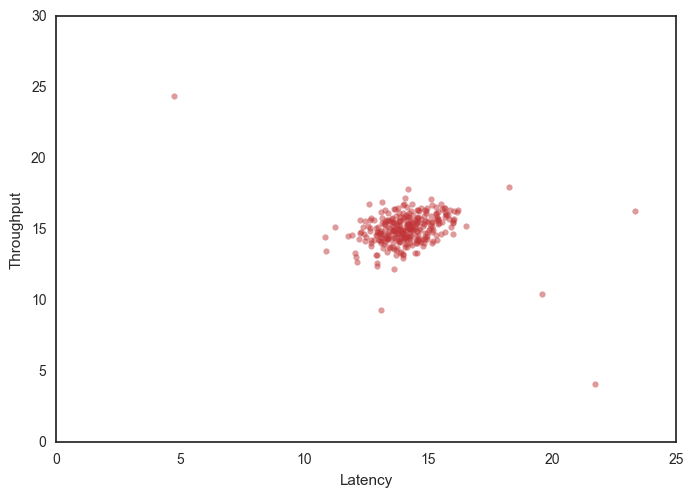

In [35]:
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})

# estimate multivariate Gaussian parameters $\mu$ and $\sigma^2$
> according to data, X1, and X2 is not independent

In [36]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)
print(cov)

[ 14.11222578  14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [37]:
# example of creating 2d grid to calculate probability density
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

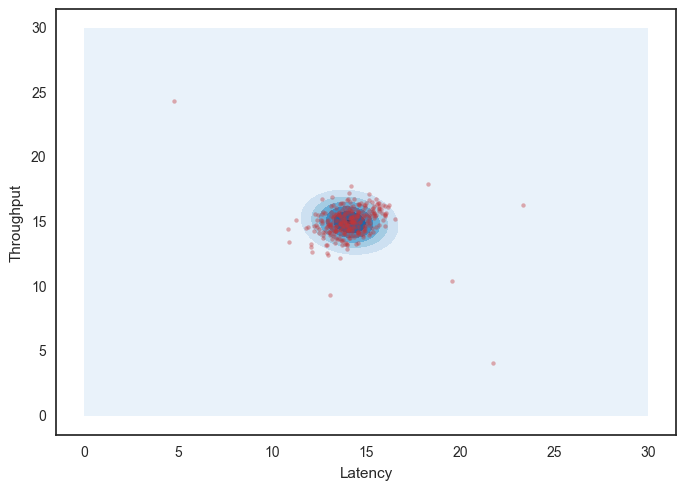

In [38]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})

# select threshold $\epsilon$
1. use training set $X$ to model the multivariate Gaussian
2. use cross validation set $(Xval, yval)$ to find the best $\epsilon$ by finding the best `F-score`

<img style="float: left;" src="../img/f1_score.png">

In [39]:
e, fs, y_pred= anomaly.select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score: {}'.format(e, fs))

Best epsilon: 3.6148577562381784e-05
Best F-score: 0.8750000000000001


# vis prediction of `Xval` using learned $\epsilon$

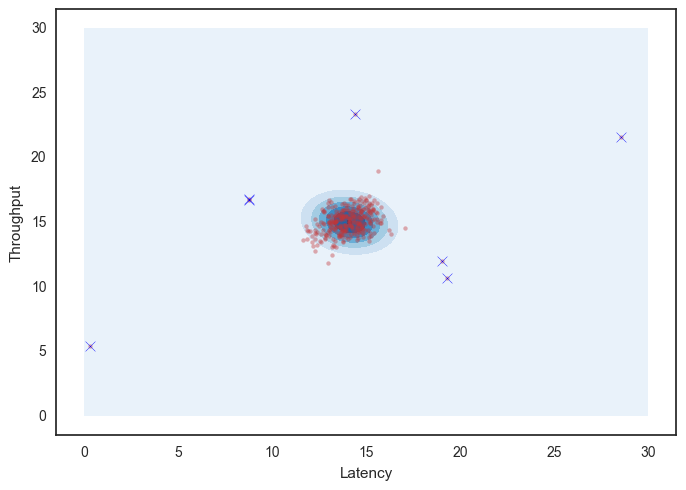

In [40]:
# construct DataFrame from Xval
data = pd.DataFrame(Xval, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create multi-var Gaussian model
mu = X.mean(axis=0)
cov = np.cov(X.T)
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly data
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)

# high dimension data

In [41]:
mat2 = sio.loadmat('./data/ex8data2.mat')
mat2.keys()

dict_keys(['__globals__', 'Xval', '__header__', 'yval', '__version__', 'X'])

In [42]:
X2, Xval2, yval2 = mat2.get('X'), mat2.get('Xval'), mat2.get('yval').ravel()
X.shape

(307, 2)

In [43]:
e, fs, y_pred = anomaly.select_threshold(X2, Xval2, yval2)

In [44]:
print('Best epsilon: {}\nBest F-score: {}'.format(e, fs))

Best epsilon: 1.74667432759803e-19
Best F-score: 0.7368421052631577


In [46]:
print('find {} anamolies'.format(y_pred.sum()))

find 9 anamolies


The huge difference between my result, `9`, and the official `117` anamolies in the ex8 is due to my use of **multivariate Gaussian**.